機械学習

## 初期設定

In [5]:
from mymodule import MLs
from mymodule import myfunc as mf
import numpy as np
import pandas as pd
import glob
import os
import re
from dotenv import load_dotenv
load_dotenv()
# root_dir = os.environ["root_dir"]
root_dir = "../"
picout = root_dir + "MLres/MLres0117_testtrainspilt/"

import cv2
def savetrimBMP(bmp, outname, xcenter, ycenter):
    bmpXlen = 1799
    bmpYlen = 570
    npyXlen = 257
    npyYlen = 1025
    xrange = 10/2
    yrange = 100/2
    def bmplocx(npylocx):
        return int(npylocx*bmpXlen/npyXlen)
    def bmplocy(npylocy):
        return int(bmpYlen-(bmpYlen*npylocy/npyYlen))
    xup, xdown = bmplocx(xcenter + xrange), bmplocx(xcenter - xrange)
    yup, ydown = bmplocy(ycenter + yrange), bmplocy(ycenter - yrange)
    im = cv2.imread(bmp,cv2.IMREAD_GRAYSCALE)
    name = os.path.basename(bmp)
    separated_im = im[yup:ydown,xdown:xup]
    cv2.imwrite(outname, separated_im)

def dosavetrimBMPs(df, outdir):
    for npypath, y, predict in zip(df["path"], df["y"], df["predict"]):
        status = f'y{y[:1]}pred{predict[:1]}'
        pattern = re.compile('[a-zA-Z_]+_')
        target = pattern.search(os.path.basename(npypath)).group()[:-1]

        pathPattern = re.compile('_\d+\.\d+\.\d+_')
        rangePattern =re.compile('_\d+\.\d+\.npy')
        pathstr = pathPattern.search(npypath).group()[1:-1]
        rangestr = rangePattern.search(npypath).group()[1:-4]
        path = pathstr.split(".")
        licpath = f"../imgout/ohnolic/snap{path[0]}/lic_snap{path[0]}.{'{0:02d}'.format(int(path[1]))}.{'{0:02d}'.format(int(path[2]))}.bmp"
        xycenter = rangestr.split(".")
        if not os.path.exists(outdir + f"{target}/{status}"):
            if not os.path.exists(outdir + f"{target}"):
                os.mkdir(outdir + f"{target}")
            os.mkdir(outdir + f"{target}/{status}")
        outname = outdir + f"{target}/{status}/{str.replace(os.path.basename(npypath),'.npy', '.bmp')}"
        savetrimBMP(licpath, outname, int(xycenter[0]), int(xycenter[1]))   
import pickle
def loadmodel(modelsdir, target, tag, methodname):
    path = modelsdir + "model_" + target + "_" + tag + "_" + methodname
    with open(path, 'rb') as f:
        return pickle.load(f) 

データの参照先の設定、インスタンス作成

In [3]:
TARGET = "pressure" #ALTIMAGES等のディレクトリにくっつけます
#それぞれ1番最後の'/'は忘れずつけること
ALTIMAGES0 = root_dir + "imgout/0131altimg0X/"#リコネクションなし分割済データフォルダ.makesepnpy.ipynbであらかじめ分割データを入れておく
ALTIMAGES1 = root_dir + "imgout/0131altimg1X/"#リコネクションあり分割済データフォルダ.makesepnpy.ipynbであらかじめ分割データを入れておく
SOURCE0 = [root_dir + "imgout/0131_not/",root_dir + "imgout/0131_1O/"]#リコネクションなしのラベリングcsvのあるフォルダ
SOURCE1 = [root_dir + "imgout/0131_1X/"]#リコネクションありのラベリングcsvのあるフォルダ
IMGSHAPE = (100,10)#出来れば画像サイズはすべて同じで合ってほしい。違うサイズが混じる場合は最も多いサイズを指定すること
# IMGSHAPE = (100,10,2)
DO_PCA = False #データ圧縮。IMGSHAPEと、データサイズが途方もなく多ければTrueにする。
randomstate = None #学習時のパラメータ。初期値はNone。結果を固定したければ1とかに設定する。

ML = MLs.ML(TARGET, ALTIMAGES0, ALTIMAGES1, SOURCE0, SOURCE1, IMGSHAPE, DO_PCA
,randomstate=randomstate
,dilute=False)

### 例

In [4]:
#学習
#モジュールに書いてるコードで実行
# model = ML.linearSVC()   
# model =ML.kneighbors()
# model =ML.rbfSVC()
# model =ML.XGBoost()
import xgboost as xgb 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
#or
#自由に記述し、MLクラスを利用して実行
from sklearn.svm import LinearSVC
def mylinearSVC(self):    
        model = LinearSVC(C=0.3, random_state=self.randomstate) # インスタンスを生成
        model.fit(self.X_train, self.y_train) # モデルの学習
        # 学習データに対する精度
        print("Train :", model.score(self.X_train, self.y_train)) 
        # テストデータに対する精度
        print("Test :", model.score(self.X_test, self.y_test)) 
        print(model.predict(self.X_test))
        pred = model.predict(self.X_test)
        svmres = pd.DataFrame(np.array([self.path_test, self.y_test, pred]).T, columns=["path", "y", "predict"])
        # print(classification_report(self.y_test, pred))
        return model
def myXGBoost(self):
    model = xgb.XGBClassifier(n_estimators=80, max_depth=4, gamma=3) # インスタンスの生成
    
    best_params = {'learning_rate': 0.23438544552825968, 'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.667695894112733, 'subsample': 0.8735879532622676, 'reg_alpha': 0.06062080789580933, 'reg_lambda': 0.02649834562029887, 'gamma': 0.00017347104196205915}
    best_params = {'learning_rate': 0.2996664042991379, 'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.5900132407505827, 'subsample': 0.7861278628111913, 'reg_alpha': 0.0833769468777452, 'reg_lambda': 0.031653801601850814, 'gamma': 0.000513312410240226}
    best_score = -7.046471479406687e-05
    model.set_params(**best_params)
    model.fit(self.X_train, self.y_train) # モデルの学習
    pred = model.predict(self.X_test)
    svmres = pd.DataFrame(np.array([self.path_test, self.y_test, pred]).T, columns=["path", "y", "predict"])
    print(classification_report(self.y_test, pred))
xg = myXGBoost(ML)
# svm = mylinearSVC(ML)

c:\Users\lkxl1\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.47      0.67      0.55      3932
         1.0       0.23      0.12      0.16      3299

    accuracy                           0.42      7231
   macro avg       0.35      0.39      0.36      7231
weighted avg       0.36      0.42      0.37      7231



In [4]:
#参照可能なもの
# ML.TARGET = TARGET#magfieldx, pressure,,,
# ML.PATH1
# ML.PATH0
# ML.ALLTARINDATA0#データ参照先フォルダ
# ML.ALLTARINDATA1
# ML.PATH0TEST#テストデータ一覧
# ML.PATH1TEST
ML.PATH0TRAIN#学習データ
# ML.PATH1TRAIN
# ML.X_test
# ML.y_test
# ML.path_test
# ML.X_train
# ML.y_train
# ML.path_train
# #後から変更可能なもの
# ML.randomstate = 1

['../imgout/0131_not/density\\density_49.1.10_141.384.npy',
 '../imgout/0131_not/density\\density_49.1.10_165.440.npy',
 '../imgout/0131_not/density\\density_49.1.10_178.427.npy',
 '../imgout/0131_not/density\\density_49.1.10_208.407.npy',
 '../imgout/0131_not/density\\density_49.1.10_24.548.npy',
 '../imgout/0131_not/density\\density_49.1.10_38.495.npy',
 '../imgout/0131_not/density\\density_49.1.10_55.616.npy',
 '../imgout/0131_not/density\\density_49.1.10_67.652.npy',
 '../imgout/0131_not/density\\density_49.1.10_69.512.npy',
 '../imgout/0131_not/density\\density_49.1.11_117.533.npy',
 '../imgout/0131_not/density\\density_49.1.11_158.490.npy',
 '../imgout/0131_not/density\\density_49.1.11_228.497.npy',
 '../imgout/0131_not/density\\density_49.1.11_229.501.npy',
 '../imgout/0131_not/density\\density_49.1.11_24.548.npy',
 '../imgout/0131_not/density\\density_49.1.11_61.479.npy',
 '../imgout/0131_not/density\\density_49.1.12_133.675.npy',
 '../imgout/0131_not/density\\density_49.1.12_1

In [ ]:
#学習モデルをファイルに保存、読み込み例
import pickle

target = "density"
tag = "X"
methodname = "svm"
path = picout + "model_" + target + "_" + tag + "_" + methodname

file = open(path, "wb") 
# pickle.dump(svm, file)
file.close

with open(path, 'rb') as f:
    dict = pickle.load(f)
print(svm)

LinearSVC(C=0.3)


## 以下自由に

In [9]:
model = ML.XGBoost()  
# model = ML.linearSVC()
# model = ML.kneighbors()
# model = ML.rbfSVC()
df = model[1]
df1 = df[df["y"] != df["predict"]]
# dosavetrimBMPs(df1, "../imgout/0131_not;1Oand/")
df1

c:\Users\lkxl1\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,path,y,predict
175,../imgout/0117_1O/density\density_49.52.10_141...,0.0,1.0
264,../imgout/0117_not/density\density_77.13.12_20...,0.0,1.0
289,../imgout/0117_not/density\density_77.43.5_89....,0.0,1.0
381,../imgout/0117_not/density\density_77.20.5_119...,0.0,1.0
497,../imgout/0117_not/density\density_77.19.5_119...,0.0,1.0
787,../imgout/0117_not/density\density_77.62.11_19...,0.0,1.0
884,../imgout/0117_1O/density\density_49.30.12_180...,0.0,1.0
1258,../imgout/0117_1O/density\density_49.51.10_141...,0.0,1.0
1402,../imgout/0117_not/density\density_77.52.10_12...,0.0,1.0
1423,../imgout/0117_1O/density\density_49.41.10_141...,0.0,1.0


# 機械学習全パターン回して、スコア表示と、モデルの保存

In [6]:
import pickle
# props = [("X","imgout/0131altimg0X/","imgout/0131altimg1X/",[root_dir + "imgout/0131_not/",root_dir + "imgout/0131_1O/"],[root_dir + "imgout/0131_1X/"]),
#  ("O","imgout/0131altimg0O/","imgout/0131altimg1O/", [root_dir + "imgout/0131_not/",root_dir + "imgout/0131_1X/"],[root_dir + "imgout/0131_1O/"])]
props = [("X","imgout/0117_not/","imgout/0117_1X/",[root_dir + "imgout/0117_not/",root_dir + "imgout/0117_1O/"],[root_dir + "imgout/0117_1X/"]),
 ("O","imgout/0117_not/","imgout/0117_1O/", [root_dir + "imgout/0117_not/",root_dir + "imgout/0117_1X/"],[root_dir + "imgout/0117_1O/"])]

# for target in ["density", "enstrophy", "pressure","magfieldx", "magfieldy", "velocityx","velocityy"]:
for target in ["density", "enstrophy", "pressure"]:
    for tag, altimages0,altimages1,sources0,sources1 in props:
        TARGET = target
        #それぞれ1番最後の'/'は忘れずつけること
        ALTIMAGES0 = root_dir + altimages0#リコネクションなし分割済データフォルダ
        ALTIMAGES1 = root_dir + altimages1#リコネクションあり分割済データフォルダ
        SOURCE0 = sources0#リコネクションありのラベリングcsvのあるフォルダ
        SOURCE1 = sources1#リコネクションなしのラベリングcsvのあるフォルダ
        IMGSHAPE = (100,10)#出来れば画像サイズはすべて同じで合ってほしい。違うサイズが混じる場合は最も多いサイズを指定すること
        DO_PCA = False #データ圧縮。IMGSHAPEと、データサイズが途方もなく多ければTrueにする。
        randomstate = None #学習時のパラメータ。初期値はNone。結果を固定したければ1とかに設定する。

        ML = MLs.ML(TARGET, ALTIMAGES0, ALTIMAGES1, SOURCE0, SOURCE1, IMGSHAPE, DO_PCA
        ,randomstate=randomstate
        ,dilute=False)
        def savemodel(model, methodname):
            path = picout +"0117_"+ "model_" + target + "_" + tag + "_" + methodname
            file = open(path, "wb") 
            pickle.dump(model, file)
            file.close()
            print("model_" + target + "_" + tag + "_" + methodname+"\n")
            ML.printscore(model)
            print("------------------\n\n")

        # model = ML.linearSVC()
        # savemodel(model, "linearSVC")
        # model = ML.kneighbors()
        # savemodel(model, "kneighbors")
        model = ML.rbfSVC()
        savemodel(model, "rbfSVC")
        # model = ML.XGBoost()
        # savemodel(model, "XGBoost")


model_density_X_rbfSVC

Train : 0.9783560311284046
Test : 0.976145038167939
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2901
         1.0       0.97      0.97      0.97      2339

    accuracy                           0.98      5240
   macro avg       0.98      0.98      0.98      5240
weighted avg       0.98      0.98      0.98      5240

------------------


model_density_O_rbfSVC

Train : 0.9286422200198216
Test : 0.9398854961832062
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      3295
         1.0       0.88      0.97      0.92      1945

    accuracy                           0.94      5240
   macro avg       0.93      0.95      0.94      5240
weighted avg       0.94      0.94      0.94      5240

------------------


model_enstrophy_X_rbfSVC

Train : 0.9651105651105651
Test : 0.9633587786259542
              precision    recall  f1-score   support

         0.0     

In [9]:
import pickle
# props = [("X","imgout/0131altimg0X/","imgout/0131altimg1X/",[root_dir + "imgout/0131_not/",root_dir + "imgout/0131_1O/"],[root_dir + "imgout/0131_1X/"]),
#  ("O","imgout/0131altimg0O/","imgout/0131altimg1O/", [root_dir + "imgout/0131_not/",root_dir + "imgout/0131_1X/"],[root_dir + "imgout/0131_1O/"])]
props = [("X","imgout/0131_not/","imgout/0131_1X/",[root_dir + "imgout/0131_not/",root_dir + "imgout/0131_1O/"],[root_dir + "imgout/0131_1X/"]),
 ("O","imgout/0131_not/","imgout/0131_1O/", [root_dir + "imgout/0131_not/",root_dir + "imgout/0131_1X/"],[root_dir + "imgout/0131_1O/"])]

for target in ["density", "enstrophy", "pressure","magfieldx", "magfieldy", "velocityx","velocityy"]:
    for tag, altimages0,altimages1,sources0,sources1 in props:
        TARGET = target
        #それぞれ1番最後の'/'は忘れずつけること
        ALTIMAGES0 = root_dir + altimages0#リコネクションなし分割済データフォルダ
        ALTIMAGES1 = root_dir + altimages1#リコネクションあり分割済データフォルダ
        SOURCE0 = sources0#リコネクションありのラベリングcsvのあるフォルダ
        SOURCE1 = sources1#リコネクションなしのラベリングcsvのあるフォルダ
        IMGSHAPE = (100,10)#出来れば画像サイズはすべて同じで合ってほしい。違うサイズが混じる場合は最も多いサイズを指定すること
        DO_PCA = False #データ圧縮。IMGSHAPEと、データサイズが途方もなく多ければTrueにする。
        randomstate = None #学習時のパラメータ。初期値はNone。結果を固定したければ1とかに設定する。

        ML = MLs.ML(TARGET, ALTIMAGES0, ALTIMAGES1, SOURCE0, SOURCE1, IMGSHAPE, DO_PCA
        ,randomstate=randomstate
        ,dilute=False)
        def savemodel(model, methodname):
            path = picout + "0117_"+"model_" + target + "_" + tag + "_" + methodname
            file = open(path, "wb") 
            pickle.dump(model, file)
            file.close()
            print("model_" + target + "_" + tag + "_" + methodname+"\n")
            ML.printscore(model)
            print("------------------\n\n")


        model = ML.XGBoost()
        savemodel(model, "XGBoost")


# snap全体に学習modelをかけて、lic上で可視化。

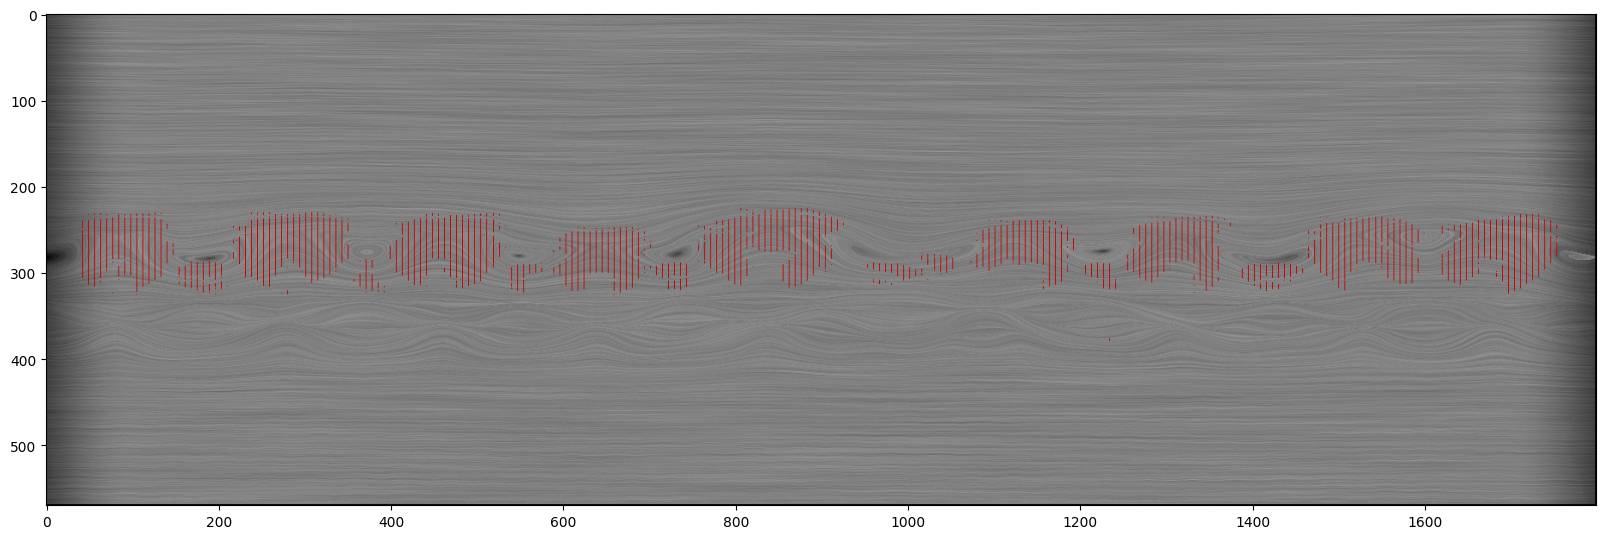

In [8]:
#rcnn的なことをして、licの画像にリコネクション点のびょうがをしたい。
import matplotlib.pyplot as plt
target = "density"#magxyはsnapをfusionnpyで作らないといけない
tag = "O"
methodname = "XGBoost"
para = 10
job = 10
dataset = 77
snap = mf.gen_snap_path(target, para, job, dataset)

#学習モデルをファイルに保存、読み込み例
import pickle
def loadmodel(modelsdir, target, tag, methodname):
    ###
    return model[0]
    ###
    path = picout + "model_" + target + "_" + tag + "_" + methodname
    with open(path, 'rb') as f:
        return pickle.load(f)[0]
# model = loadmodel(picout, target, tag, methodname)
# model = model[0]
model = model[0]
import cv2
def P(snappath, model):
    
    def bmplocx(npylocx):
        bmpXlen = 3598
        # npyXlen = 257
        npyXlen = 513
        return int(npylocx*bmpXlen/npyXlen)
    def bmplocy(npylocy):
        bmpYlen = 570
        npyYlen = 1025
        return int(bmpYlen-(bmpYlen*npylocy/npyYlen))
    xrange = int(10/2)
    yrange = int(100/2)
    def trimnpy(im, xcenter, ycenter):
        xup, xdown = (xcenter + xrange), (xcenter - xrange)
        yup, ydown = (ycenter + yrange), (ycenter - yrange)
        res = im[ydown:yup,xdown:xup]
        # print(im)
        res = np.array(((res - min(res.flat)) / max(res.flat)).flat)
        return res
    def drawOnBMP(licpath, locs):#########点の描画とかにするかも
        # xup, xdown = bmplocx(xcenter + xrange), bmplocx(xcenter - xrange)
        # yup, ydown = bmplocy(ycenter + yrange), bmplocy(ycenter - yrange)
        lic = cv2.imread(licpath)
        for loc in locs:
            x, y = bmplocx(loc[1]), bmplocy(loc[0])
            lic[bmplocy(loc[0]),bmplocx(loc[1])] = [200,0,0]
        return lic


        # return im[yup:ydown,xdown:xup]
    im = (mf.load(snappath))
    ys = range(51,im.shape[0]-51)
    # xs = range(6,im.shape[1]-6)
    xs = range(6,251)
    len_ysxs = len(xs)*len(ys)
    # separated = {"loc":[[0,0,0,0] for i in range(len_ysxs)], "im":[], "preds":[]}
    separated = {"loc":[], "im":[], "preds":[]}
    # i_count = 0
    for y in ys:
        for x in xs:
            separated["im"].append(trimnpy(im, x,y))
            separated["loc"].append((y,x))

            # separated["im"][i_count,:] = trimnpy(im,x,y)
            # i_count += 1
    separated["preds"] = model.predict(separated["im"])
    reconnectings = []
    for i in range(len(separated["im"])):
        if separated["preds"][i]:
            reconnectings.append(separated["loc"][i])
    licpath = f"../imgout/ohnolic/snap{dataset}/lic_snap{dataset}.{'{0:02d}'.format(int(para))}.{'{0:02d}'.format(int(job))}.bmp"
    return drawOnBMP(licpath, reconnectings)
    # cv2.imwrite(outname, separated_im)

lic = P(snap, model)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
plt.imshow(lic)
plt.show()

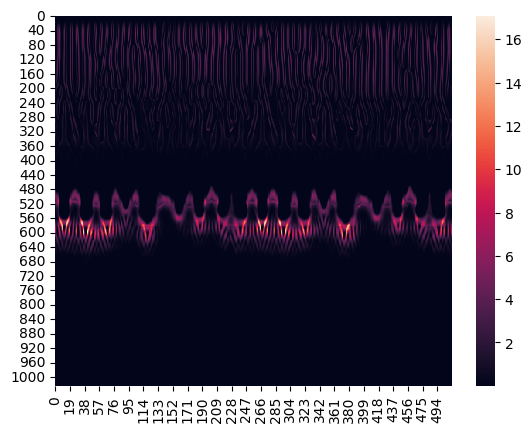

In [18]:
mf.show(mf.load(mf.gen_snap_path("enstrophy", para, job, dataset)))

In [9]:
print(model[2])

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5688
         1.0       1.00      1.00      1.00      4560

    accuracy                           1.00     10248
   macro avg       1.00      1.00      1.00     10248
weighted avg       1.00      1.00      1.00     10248



In [6]:
print(model[])

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      3932
         1.0       0.96      0.98      0.97      3299

    accuracy                           0.97      7231
   macro avg       0.97      0.97      0.97      7231
weighted avg       0.97      0.97      0.97      7231



In [12]:
ML.PATH1

['../imgout/0131_1X/density\\density_49.1.10_108.517.npy',
 '../imgout/0131_1X/density\\density_49.1.10_132.510.npy',
 '../imgout/0131_1X/density\\density_49.1.10_191.526.npy',
 '../imgout/0131_1X/density\\density_49.1.10_203.470.npy',
 '../imgout/0131_1X/density\\density_49.1.10_215.528.npy',
 '../imgout/0131_1X/density\\density_49.1.10_247.517.npy',
 '../imgout/0131_1X/density\\density_49.1.10_33.530.npy',
 '../imgout/0131_1X/density\\density_49.1.10_54.539.npy',
 '../imgout/0131_1X/density\\density_49.1.10_76.528.npy',
 '../imgout/0131_1X/density\\density_49.1.10_90.481.npy',
 '../imgout/0131_1X/density\\density_49.1.11_108.517.npy',
 '../imgout/0131_1X/density\\density_49.1.11_131.512.npy',
 '../imgout/0131_1X/density\\density_49.1.11_152.539.npy',
 '../imgout/0131_1X/density\\density_49.1.11_191.526.npy',
 '../imgout/0131_1X/density\\density_49.1.11_202.456.npy',
 '../imgout/0131_1X/density\\density_49.1.11_215.528.npy',
 '../imgout/0131_1X/density\\density_49.1.11_23.451.npy',
 '